In [424]:
from scipy.optimize import minimize, LinearConstraint, Bounds, dual_annealing, differential_evolution
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.neural_network import MLPRegressor

### Zad1

x_1 + x_2 =< 60   
5x_1 + 10x_2 =< 400   

5x_1 =< 250   
4x_2 =< 120   

In [425]:
def objective_function(x):
    f = x[0] * 5 * 30 + x[1] * 4 * 50 - (5 * x[0] + 10 * x[1]) * 10
    return -f

In [426]:
bounds = Bounds([0, 0], [50, 30])
constrains = LinearConstraint([[1, 1], [5, 10]], [0, 0], [60, 400])
out_max = minimize(objective_function, [100, 100], method='SLSQP',
                   bounds=bounds, constraints=constrains)
out_max

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -5999.999999975722
       x: [ 4.000e+01  2.000e+01]
     nit: 2
     jac: [-1.000e+02 -1.000e+02]
    nfev: 6
    njev: 2

In [427]:
def plot3d(fun, x1, x2, op, title):
    x, y = np.meshgrid(x1, x2)
    z = fun([x, y])
    z_op = fun([op[:, 0], op[:, 1]])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.plot_surface(x, y, z, alpha=0.7, cmap='viridis')
    ax.scatter(op[:, 0], op[:, 1], z_op, alpha = 1, color='red', s=10)
    ax.plot

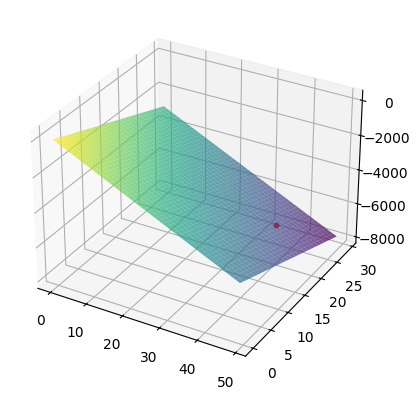

In [428]:
x = np.arange(0, 50)
y = np.arange(0, 30)
plot3d(objective_function, x, y, np.array([out_max.x]), "")

### Zad 2

In [429]:
def fun(x):
    return (x[0] - 5)**2 + (x[1] - 8) **2 + 100

In [430]:
class Trajectory:
    def __init__(self):
        self._fun = None
        self._trace_points = None

    def _objective_function(self, x, *args):
        res = self._fun(x)
        self._trace_points.append(x)
        return res

    def minimalize_simplex(self, fun, x0):
        self._trace_points = []
        self._fun = fun
        return minimize(self._objective_function, x0, 'Nelder-Mead')

    def minimalize_gradient(self, fun, x0):
        self._trace_points = []
        self._fun = fun
        return minimize(self._objective_function, x0, 'CG')

    def minimalize_annealing(self, fun, bounds):
        self._trace_points = []
        self._fun = fun
        return dual_annealing(self._objective_function, bounds)

    def minimalize_evolution(self, fun, bounds):
        self._trace_points = []
        self._fun = fun
        return differential_evolution(self._objective_function, bounds)

    @property
    def trace_points(self):
        return np.row_stack(self._trace_points)

In [431]:
lb = [-100, -100]
ub = [100, 100]
x = np.arange(lb[0], ub[0])
y = np.arange(lb[0], ub[0])
tr = Trajectory()

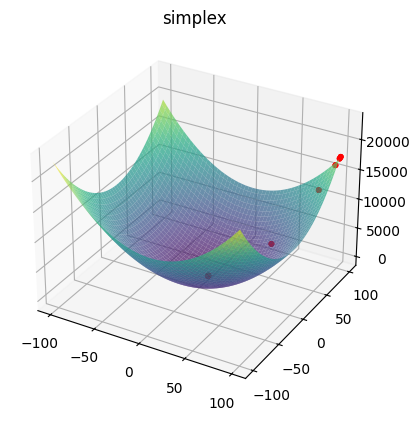

In [432]:
out = tr.minimalize_simplex(fun, [100, 100])
plot3d(fun, x, y, tr.trace_points, "simplex")

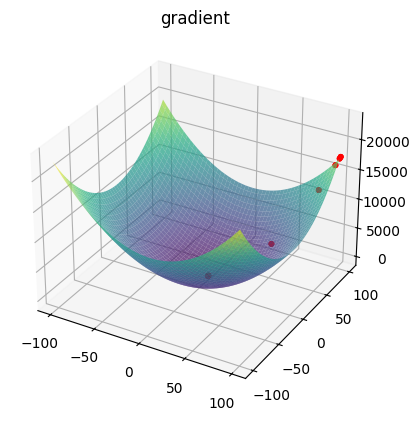

In [433]:
out = tr.minimalize_gradient(fun, [100, 100])
plot3d(fun, x, y, tr.trace_points, "gradient")

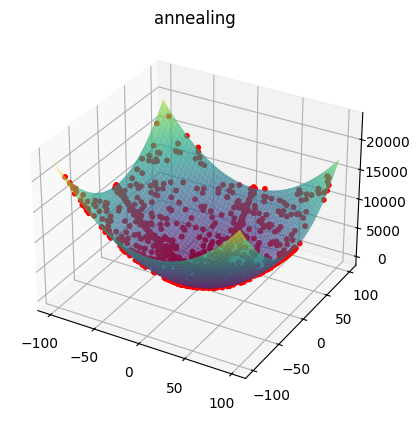

In [434]:
lb = [-100, -100]
ub = [100, 100]

out = tr.minimalize_annealing(fun, list(zip(lb, ub)))
plot3d(fun, x, y, tr.trace_points, "annealing")

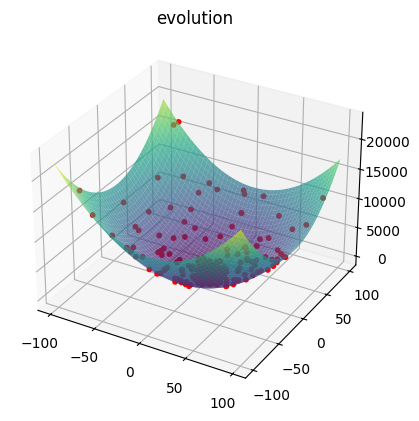

In [435]:
out = tr.minimalize_evolution(fun, list(zip(lb, ub)))
plot3d(fun, x, y, tr.trace_points, "evolution")

### Zad3

In [506]:
class Siec:
    activ=lambda self,x: (x+abs(x))/2 # ReLU
    # activ=lambda self,x: 1/(1+math.exp(-x)) # Sigmoid
    def __init__(self, wezly, warstwy):
        self.L=wezly
        self.M=warstwy
        self.N=self.L+2
        if warstwy==1:
            self.N=2

        self.xij=np.zeros(self.L*self.M).reshape((self.L,self.M))
        self.wij=np.zeros(self.L*self.N).reshape((self.L,self.N))

    def get_wagi(self):
        return self.wij

    def set_wagi(self, w):
        self.wij=w.copy()

    def losuj_wagi(self):
        for i in range(0,self.L):
            for j in range(0,self.N):
                # self.wij[i,j]=random.random() # skalowanie wag w zakresie np. [0:1]/N
                self.wij[i,j]=random.random()/2 # np. losowe [0.:0.5]
                # self.wij[i,j]=random.random()-0.5 # np. losowe [-0.5:0.5]

    def oblicz(self,x):
        self.xij[:,0]=[self.activ(self.wij[i,0]*x) for i in range(0,self.L)]
        for k in range(1,self.M):
            for j in range(1,self.N):
                for i in range(0,self.L):
                    self.xij[i,k]=sum([self.activ(self.wij[i,j]*xi) for xi in self.xij[:,k-1]])
                    y=sum([self.activ(self.wij[i,self.N-1]*self.xij[i,self.M-1]) for i in range(0,self.L)])

        return y

    def mse(self, f, x_val):
        return (f(x_val) - self.oblicz(x_val))**2


In [507]:
f=lambda x: x**2
sn=Siec(10,2) #10 węzłów i 2 warstwy ukryte
x=1.0
sn.losuj_wagi()

In [508]:
# uczenie
min_mse = np.inf
weights = None

for _ in range(0, 1000):
    sn.losuj_wagi()
    mse_val = sn.mse(f, x)
    if mse_val < min_mse:
        min_mse = mse_val
        weights = sn.get_wagi().copy()

sn.set_wagi(weights)

print("Koniec uczenia")
print("dla x=",x, "-> f(x)=", f(x))
print("dla x=",x, "i wylosowanych wag -> SN(x)=", sn.oblicz(x))
print("Błąd MSE:",(f(x)-sn.oblicz(x))**2)

Koniec uczenia
dla x= 1.0 -> f(x)= 1.0
dla x= 1.0 i wylosowanych wag -> SN(x)= 1.0016293410843773
Błąd MSE: 2.654752369239761e-06


0.9259718699199767


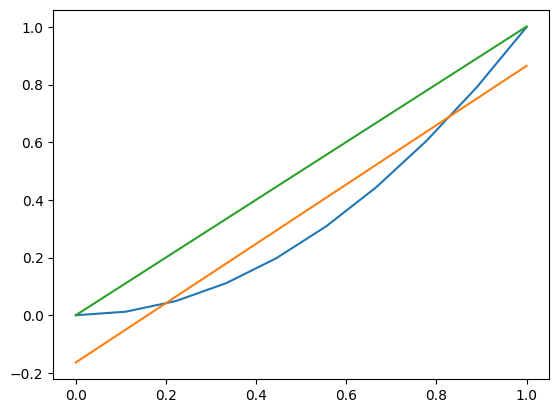

In [518]:
x_data = np.linspace(0, 1, 10)
y_data = f(x_data)

x_data_set = x_data[np.newaxis].T
y_data_set = y_data

mplr = MLPRegressor((100), activation='identity', max_iter=1000)
mplr.fit(x_data_set, y_data_set)
y_predicted = mplr.predict(x_data_set)

print(mplr.score(x_data_set, y_data_set))

plt.plot(x_data, y_data, label='funkcja')
plt.plot(x_data, y_predicted, label='siec')
plt.plot(x_data, [sn.oblicz(x) for x in x_data], label="MLRPRegressor")
plt.legend()